## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

**You must build an algorithm that:**

-- estimates pulse rate from the PPG signal and a 3-axis accelerometer.
-- assumes pulse rate will be restricted between 40BPM (beats per minute) and 240BPM
-- produces an estimation confidence. A higher confidence value means that this estimate should be more accurate than an estimate with a lower confidence value.
-- produces an output at least every 2 seconds.

**tips**

-- Remember to bandpass filter all your signals. Use the 40-240BPM range to create your pass band.

-- Use plt.specgram to visualize your signals in the frequency domain. You can plot your estimates on top of the spectrogram to see where things are going wrong.

-- When the dominant accelerometer frequency is the same as the PPG, try picking the next strongest PPG frequency if there is another good candidate.

-- Sometimes the cadence of the arm swing is the same as the heartbeat. So if you can't find another good candidate pulse rate outside of the accelerometer peak, it may be the same as the accelerometer.

--One option for a confidence algorithm is to answer the question, "How much energy in the frequency spectrum is concentrated near the pulse rate estimate?" You can answer this by summing the frequency spectrum near the pulse rate estimate and dividing it by the sum of the entire spectrum.


### Code

In [ ]:
!pip install seaborn --upgrade

In [4]:
import glob

import numpy as np
import pandas as pd
import scipy as sp
import scipy.io
import math
from collections import Counter

from scipy.signal import butter
from scipy.signal import filtfilt
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.signal import medfilt



def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls
def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ecg, ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[:]
def LoadTroikaDataReferenceFile(ref_fl):
    """
    Loads reference data.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        bpm_refs = LoadTroikaDataReferenceFile(ref_fls[0])

    Args:
        ref_fl: (str) filepath to a troika reference .mat file.

    Returns:
        numpy arrays for ref_bpms .
    """
    data = sp.io.loadmat(ref_fl)['BPM0']
    ret = list(data[:,0])
    return ret
def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    ret = np.mean(np.abs(best_estimates))
    return ret
def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

    """
    Pass band filter function
    """
def filter_band(signal,fs,pass_band=None):
    if pass_band:
        #nyquist = 0.5 * fs
        #normalized_pass_band = (pass_band[0] / nyquist, pass_band[1] / nyquist)
        #b, a  = sp.signal.butter(3, normalized_pass_band, btype='bandpass', fs=fs)
        b, a  = butter(3, pass_band, btype='bandpass', fs=fs)
        return filtfilt(b, a, signal)
    else:
        return signal
    
def hampel_filter(y, window_size=3, threshold=3):
    """
    Apply the Hampel filter to smooth out extreme values in the signal.
    
    Parameters:
    - y: The input signal.
    - window_size: The size of the window for the median filter.
    - threshold: The threshold for identifying outliers.
    
    Returns:
    - Smoothed signal.
    """
    # Apply median filter to obtain the median absolute deviation (MAD)
    mad = medfilt(np.abs(y - np.median(y)), kernel_size=window_size)
    
    # Identify outliers based on the threshold
    outliers = np.where(mad > threshold * np.std(y))
    
    # Replace outliers with the median value
    y_filtered = np.copy(y)
    y_filtered[outliers] = np.median(y)
    
    return y_filtered    
    
def compute_acceleration_resultant(accx, accy, accz):
    """
    Compute the resultant of the acceleration
    """    
    
    resultant_acceleration = np.sqrt(accx**2 + accy**2 + accz**2)
    return resultant_acceleration    
def extract_motion_from_accelerometer(acc,fs,window,step):
    """
    Extract motion using spectrogram
    """
    spec,freqs, _, _ = plt.specgram(acc,NFFT=window*fs,Fs=fs,noverlap=step*fs)
    rates = freqs[np.argmax(spec,axis=0)]
    return rates 
def extract_signal_segments(signal,fs,window,step):
    """
    Extract segement of temoral windows of size window each step.
    
    """
    segments = []
    signal_length = len(signal)
    #convertion -> index
    window = window * fs
    step = step*fs
    
    i=0
    idx_s=0
    idx_e=0
    while idx_e < signal_length:
        idx_s = i * step
        idx_e = idx_s +  window
        if(idx_e>=signal_length):            
            idx_e= signal_length
        segment = signal[idx_s:idx_e]
        segments.append(segment)
        i += 1
    return(segments)
def extract_frequencies_for_highest_amplitudes(signal,fs,window,step,pass_band=None,n=2,display= False):
    """
    Extracts n frequencies corresponding to n highest amplitude of Fourier Transform of the signal.

    Args:
        signal: signal
        fs: sampling frequency
        window: window of the within the signal
        step: window's overlaping
        pass_band: pass band frequencies interval

    Returns:
        return the n frequencies and assciate SNR ratio
   """       
    #filter signal by pas_band
    signal = filter_band(signal,fs,pass_band=pass_band)
    frequencies = []
    snrs = [] 
    segments = extract_signal_segments(signal,fs,window,step);
    for segment in segments:
        segment_pulsations= extract_ntop_freq(segment,fs,n=n)
        segment_snrs = []        
        for pulsation in segment_pulsations:
            snr = compute_SNR(segment, fs, pulsation ,6/60,display=False)
            segment_snrs.append(snr)
        frequencies.append(zip(segment_pulsations,segment_snrs))
    return frequencies
    
def extract_ntop_freq(sig, fs,n=3,display= False):
    """
    Extract the first n frequence corresponding to the highest magniture     
    
    Args:
        sig: the signal. 
        fs: sampling frequency
        n: the number of wanted frequencies 
        display: for debug or understandin
    Returns:
        The SNR coeficient
    """     
    mag = np.abs(np.fft.rfft(sig))
    frq = np.fft.rfftfreq(len(sig),1/fs) 

    # Assuming mag and frq are your Fourier Transform magnitude and frequency arrays
    # Find the indices of the top three max amplitudes
    top_indices = np.argsort(mag)[-n:][::-1]

    # Extract the corresponding frequencies
    top_frequencies = frq[top_indices]
    return top_frequencies
def compute_SNR(sig, fs, fr_p ,fr_w,display=False):
    """
    Compute the SNR of the signal around frequence fr_p with the window fr_w
    Args:
        sig: the signal. 
        fs: sampling frequency
        fr_p: frequence 
        fr_w: frequence window
        display: for debug or understandin

    Returns:
        The SNR coeficient

    """
    # Compute signal power and noise power
    signal_power = None
    noise_power = None

    mag = np.abs(np.fft.rfft(sig))
    frq = np.fft.rfftfreq(len(sig),1/fs)

    #1st harmonique
    fr_h = fr_p * 2

    f_w_p = (frq > (fr_p -fr_w))  & (frq < (fr_p + fr_w))
    f_w_h = (frq > (fr_h-fr_w))  & (frq < (fr_h + fr_w))

    f_w_no = ~ (f_w_p | f_w_h)

    if display:
        plt.clf()
        plt.plot(frq,mag)    
        plt.show()

    signal_power  = np.sum(mag[f_w_p | f_w_h])
    noise_power = np.sum(mag[f_w_no])
    # Compute SNR
    snr = signal_power / noise_power
    snr = 10 * math.log10 (100*snr)
    return snr


def select_most_common_with_max_coefficient(values, coefficients):
    """
     This code first counts the occurrences of each value and then selects the most common one. In case of ties, 
     it compares the corresponding coefficients to choose the one with the maximum coefficient and return it with the  
     percentage and the maximum coefficient associated with that value.
     Args:
         List of values  
         List of coefficients  
     Returns:
         most common values with maximum coefficient
         percentage of  this value within the whole set
         maximum coefficient
    
    """
    # Combine values and coefficients into tuples for easier processing
    combined_data = list(zip(values, coefficients))

    # Count occurrences of each value
    value_counts = Counter(values)

    # Find the most common values
    most_common_values = [item[0] for item in value_counts.most_common()]

    # If there are multiple most common values, select the one with the maximum coefficient
    selected_value = max(most_common_values, key=lambda val: next(item[1] for item in combined_data if item[0] == val))

    # Calculate the percentage of the selected value compared to all values
    total_values = len(values)
    percentage = (value_counts[selected_value] / total_values)

    # Find the maximum coefficient associated with the selected value
    max_coefficient = max(item[1] for item in combined_data if item[0] == selected_value)

    return selected_value,percentage, max_coefficient


def evaluate_bpm(ppg_sources,acc_source,snr_threshold = 15):

    """
    Evaluate the heartbeat in beat by minutes, based on multiple ppg signal sources and an accelerometer resultant signal.
    Note: The confidence isn't an accurate metrics but we have tried to gives some result based on:
          - there is a high probability tha the measure is accurate when multiple ppg captors gives the same result.
          - the snr ration is considered faire above the  snr_thresold (default value is 15 DB) and low bellow that thresold
    Args:
        ppg_sources: frequncies for highest amplitude of the FFT and coresponding SNR for multiple PPG signals.
        ppg_sources: frequncies for highest amplitude of the FFT and coresponding SNR for accelerometer signal.
        snr_threshold: thershold. fair signal quality above 15 and loq bellow 

    Returns:
        The heartbeat in BPM and a confidence percentage 
    """
    
    #lookup for first frequency which isn't 0 
    move_frequence = None 
    for pulse_acc,_ in  acc_source:
        if pulse_acc != 0:
            move_frequence = pulse_acc
            break
            
    eval_bpm = 0
    confidence = 0
    freqs = []
    snrs = []
    if isinstance(ppg_sources, list):
        for ppg_source in ppg_sources:
            for pulse_ppg,snr_ppg in ppg_source:
                if pulse_ppg != move_frequence:
                    freqs.append(pulse_ppg)
                    snrs.append(snr_ppg)
                    break
                    
        eval_frq, most_common_pulse_percent,max_snr= select_most_common_with_max_coefficient(freqs,snrs)            
        #combine found frequency with snr
        #pulse_snr_pairs = list(zip(freqs,snrs))
        #prioritize when a value occure the most of time
        #most_common_pulse, count = Counter(freqs).most_common(1)[0]
        #find the occurence to get max snrs
        #common_pulse_snr_pairs = [pulse_snr_pair for pulse_snr_pair in pulse_snr_pairs if pulse_snr_pair[0] == most_common_pulse]
        #max_snr = max(common_pulse_snr_pairs, key=lambda x: x[1])[1]
        #most_common_pulse_percent = count/len(freqs)
        #rules to be affined 
        #from the multiple ppg signal we select the most common signal
        eval_bpm = eval_frq*60
        
        #Rules to compute the cofidence
        #1. **Compute coeff1:**
        #   - Calculate how common the signal is among all signals, expressed as a percentage.
        #   - coeff1 represents this percentage.
        #  
        #2. **Compute coeff2:**
        #   - Identify the signal with the highest Signal-to-Noise Ratio (SNR).
        #   - Apply the following rule for coeff2:
        #      - If SNR is greater than the threshold (15), then coeff2 = 0.75.
        #      - If SNR is less than or equal to the threshold, then coeff2 = 0.40.
        #
        #3. **Calculate confidence:**
        #   - Multiply coeff1 by coeff2 to obtain the confidence value.
        confidence = 0
        
        if max_snr > snr_threshold: 
            confidence = 0.75
        else:
            confidence = 0.40

        confidence = confidence * most_common_pulse_percent
    
    return eval_bpm, confidence
    
    
    
    
def RunPulseRateAlgorithm(data_fl, ref_fl):
    # filtering band to retrieve pulsation
    pass_band = (40/60,240/60)
    # sample frequencies
    fs=125
    threshold = 15
    
    # Load data using LoadTroikaDataFile
    _,ppg1, ppg2, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    #constant from study: TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise
    window = 8
    step = 2
    
    acc = compute_acceleration_resultant(accx,accy,accz)
    freqencies_acc = extract_frequencies_for_highest_amplitudes(acc,
                                                                fs,
                                                                window,
                                                                step,
                                                                pass_band=pass_band,
                                                                display=False)
    
    frequencies_ppg_1 = extract_frequencies_for_highest_amplitudes(ppg1,
                                                                   fs,
                                                                   window,
                                                                   step,
                                                                   pass_band=pass_band,
                                                                   display=False)
    
    frequencies_ppg_2 = extract_frequencies_for_highest_amplitudes(ppg2,
                                                                   fs,
                                                                   window,
                                                                   step,
                                                                   pass_band=pass_band,
                                                                   display=False)
    
    
    """
    pulsations_segments_ecg,pulsation_mean_ecg,pulsation_std_ecg = extract_heart_pulsations_from_ecg(ecg,
                                                                                                     fs,
                                                                                                     window,
                                                                                                     step,
                                                                                                     pass_band=pass_band,
                                                                                                     display=True)
    """

    
    #ppg_top_frq=extract_ntop_freq(ppg,fs,n=6,display=False)
    #acc_top_frq=extract_ntop_freq(acc,fs,n=6,display=False)
    ref_bpms = LoadTroikaDataReferenceFile(ref_fl)
    display = False
      
    eval_bpms = []
    confidences = []
    for i in range(len(frequencies_ppg_1)):
       
       #print(f'batch {i*window} s - {(i+1)*window} s')
       
       #eval_bpm, confidence= evaluate_bpm([frequencies_ppg_1[i],frequencies_ppg_2[i]],freqencies_acc[i],snr_threshold = 15)
       eval_bpm, confidence= evaluate_bpm([frequencies_ppg_2[i]],freqencies_acc[i],snr_threshold = 15)

       eval_bpms.append(eval_bpm)
       confidences.append(confidence)
    
    l_eval = len(eval_bpms)
    l_ref = len(ref_bpms)
    delta = l_eval - l_ref
    errors = None
    
    reliabilities = np.array(confidences)
    if delta < 0:
        delta = -delta
        errors = np.abs( np.array(eval_bpms) -  np.array(ref_bpms)[:-delta])
        ## add missing (-1) to error
        errors = np.concatenate((errors, np.full(delta, -1) ))
    elif delta > 0:
        errors = np.abs( np.array(eval_bpms[:-delta]) -  np.array(ref_bpms))
        ## add extra (-2) to error
        errors = np.concatenate((errors, np.full(delta, -2) ))
    else:
        errors = np.abs( np.array(eval_bpms) -  np.array(ref_bpms))

    #print(f'{len(reliabilities)} = {len(errors)}')
        
    if display:
        #sns.lineplot(y='Eval',  ci=95, data=df,label='eval')
        # ci=None, marker='o'
        #sns.lineplot(data= df, ci=95, marker='o')
        #plt.show()

        plt.clf()
        plt.plot(eval_bpms)
        plt.plot(ref_bpms)
        plt.show()
        

    return errors, reliabilities

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

In [6]:
def evaluate_performance(errors, tolerance=20):
    """Evaluates algorithm performance for a single dataset.
    
    inspitred from previous lesson
    
    It is not expected that reference and estimate peak indices overlap exactly.
    Instead say a QRS estimate is correct if it is within <tolerance_samples> of
    a reference estimate.

    Args:
        errors: difference between ground-truth and eveluated signal.
        delta: (number) How close the ground-truth signal estimate should be.
    Returns:
        n_correct: (number) The number of measurments that were correctly detected ( close enougth)
        n_missed: (number) The number of measurments that the algorithm failed
            to detect
    """
    # Keep track of the number of data correctly idetified
    n_correct = 0
    # ... that were incoretly identified
    n_missed = 0
    n_extra = 0
    
    for error in errors:
        #print(f'error = {error} <= {tolerance}')
        if error == -2:
            n_extra += 1
        elif error == -1:
            n_missed += 1
        elif error <= tolerance:
            n_correct += 1
        else:   
            n_missed += 1    
                
    ## n_extra = false positive
    ## n_correct = true positive
    ## n_missed = fasle negavive
    # recall = True positive/ (True posittive + False negative)
    # precision True positive / (True positive + False positive)
    precision = n_correct / (n_correct + n_extra)
    recall = n_correct / (n_correct + n_missed)
    return precision, recall

Files number: 12
**************************************************
rest(30s) -> 8km/h(1min) -> 15km/h(1min) -> 8km/h(1min) -> 15km/h(1min) -> rest(30s)
recall: 0.4391891891891892


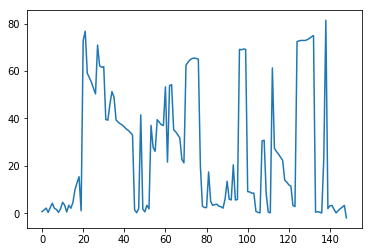

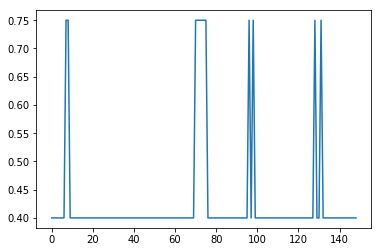

**************************************************
**************************************************
rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)
recall: 0.47297297297297297


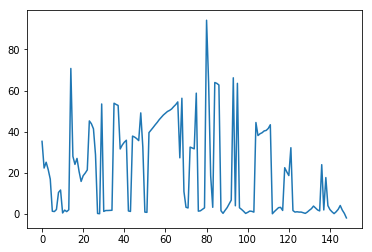

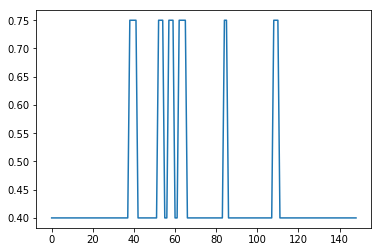

**************************************************
**************************************************
rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)
recall: 0.7714285714285715


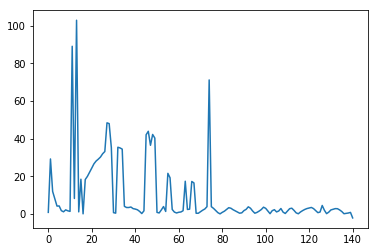

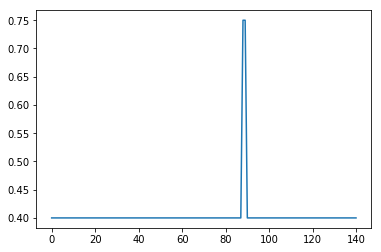

**************************************************
**************************************************
rest(30s) -> 8km/h(1min) -> 15km/h(1min) -> 8km/h(1min) -> 15km/h(1min) -> rest(30s)
recall: 0.6635514018691588


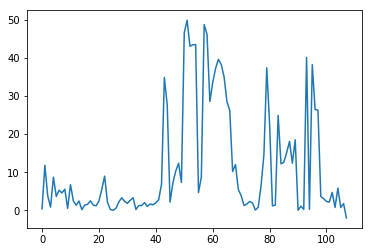

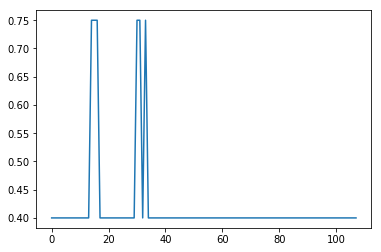

**************************************************
**************************************************
rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)
recall: 0.7191780821917808


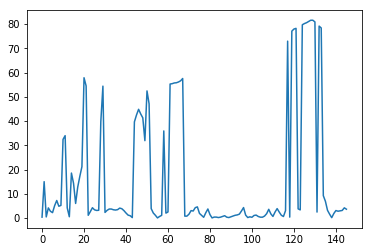

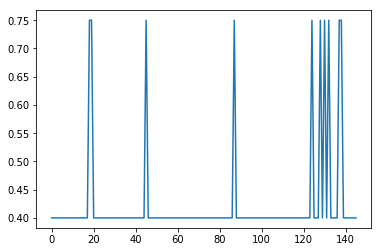

**************************************************
**************************************************
rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)
recall: 0.7054794520547946


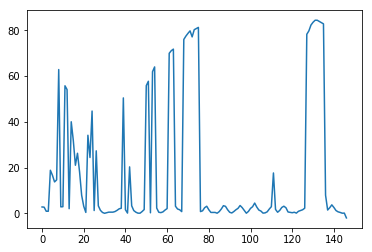

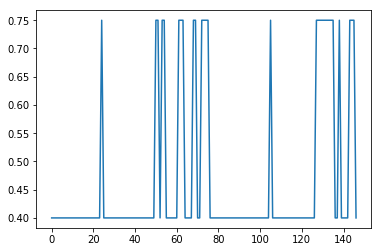

**************************************************
**************************************************
rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)
recall: 0.44


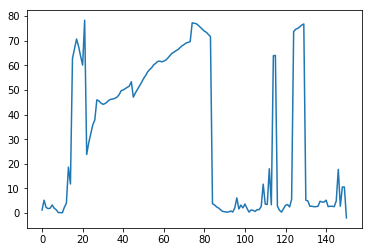

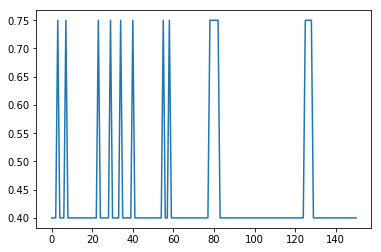

**************************************************
**************************************************
rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)
recall: 0.5314685314685315


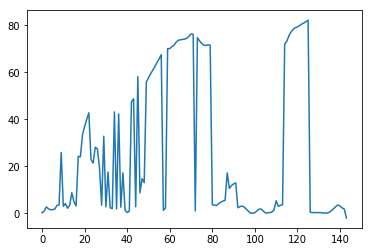

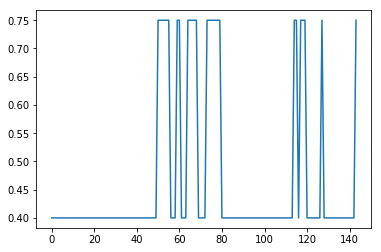

**************************************************
**************************************************
rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)
recall: 0.6


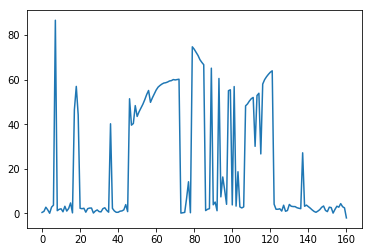

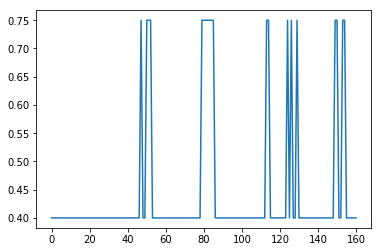

**************************************************
**************************************************
rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)
recall: 0.348993288590604


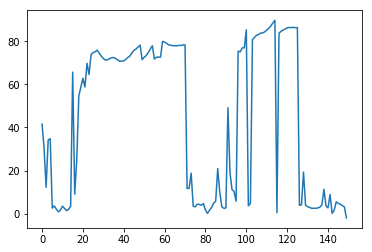

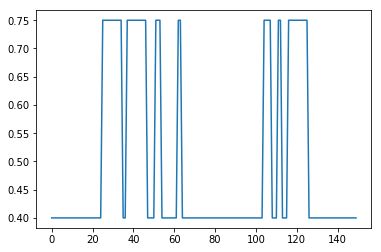

**************************************************
**************************************************
rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)
recall: 0.42657342657342656


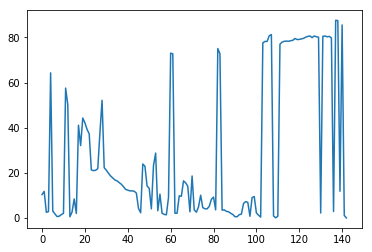

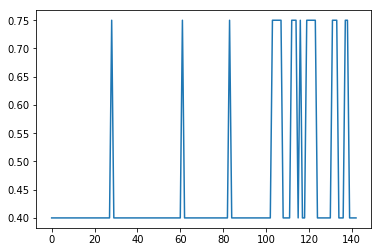

**************************************************
**************************************************
rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)
recall: 0.21232876712328766


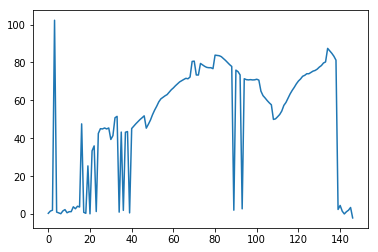

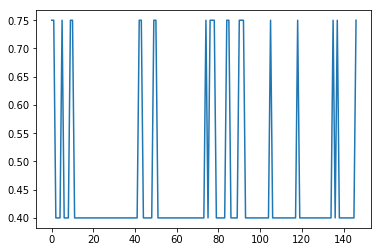

**************************************************
recall mean : 0.5275969736218598
recall max : 0.7714285714285715
recall min : 0.21232876712328766
recall std : 0.1611190455607619
Type 1 : 2, Type 2: 10


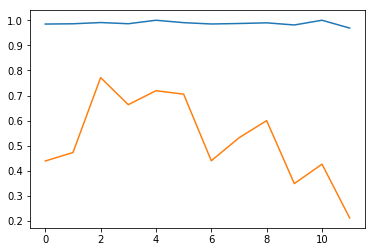

In [15]:
#some visualization
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal
import math
from os.path import split

data_fls, ref_fls = LoadTroikaDataset()

print(f'Files number: {len(data_fls)}')
type1= 0
type2= 0
recalls = []
precisions = [] 
for data_fl, ref_fl in zip(data_fls, ref_fls):
    display= True

    errors,confidences= RunPulseRateAlgorithm(data_fl, ref_fl)

    precision,recall = evaluate_performance(errors, tolerance=10)        
    if display:
        print('**************************************************')   
        if 'TYPE01' in ref_fl:
            print('rest(30s) -> 8km/h(1min) -> 15km/h(1min) -> 8km/h(1min) -> 15km/h(1min) -> rest(30s)')
            type1 += 1
        if 'TYPE02' in ref_fl:
            print('rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)')
            type2 += 1
        precisions.append(precision)
        recalls.append(recall)
        print(f'recall: {recall}')
        plt.clf()
        plt.plot(errors)
        plt.show()
    
        plt.clf()
        plt.plot(confidences)
        plt.show()
        print('**************************************************') 
if display:
    print(f'recall mean : {np.mean(recalls)}')
    print(f'recall max : {np.max(recalls)}')
    print(f'recall min : {np.min(recalls)}')
    print(f'recall std : {np.std(recalls)}')
    print(f'Type 1 : {type1}, Type 2: {type2}')
    
    plt.clf()
    plt.plot(precisions)
    plt.plot(recalls)
    plt.show()


In [16]:
#Test evaludation for test validation
print(Evaluate())

26.1100115968



-----
### Project Write-up

## Goal ##


The goal of this project was the development of a an algorythm able to evalueate the heartbeat pulsation of human with ppg captors and eccelerometer and to find a method to eveluate the confidence in the evalutation.
The set of data used is extracted from a study named **TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise** [https://arxiv.org/pdf/1409.5181.pdf] which studied the varation of pulsation of individuals under two differents condition of training.

--------

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

- **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 

    In order to get the errors and the  confidences ,use the entry point function:
    
        def RunPulseRateAlgorithm((data_fl, ref_fl): 
                              
    used as follow
                              
        errors,confidences= RunPulseRateAlgorithm(data_fl, ref_fl)
                              
    
     where   data_fl and ref_fl are the paath to respectively the data extractcted from captors and reference data which which are the ground truth data:

    ex:

    ./datasets/troika/training_data/DATA_01_TYPE01.mat
    ./datasets/troika/training_data/REF_01_TYPE01.mat

    The folloing function for a set of errors returned by RunPulseRateAlgorithm return the precision and the recall

        def evaluate_performance(errors, tolerance=20):

    used as follow:

        precision,recall = evaluate_performance(errors, tolerance=10)
        print(f'pecision: {precision}')
        print(f'recall: {recall}')

- **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.

	The data used were collected by 2 type of captor recorded from wearer wrist:

- PPG:
  definition given by the original study [https://arxiv.org/pdf/1409.5181.pdf] :

> PPG signals are optically obtained by pulse oximeters. Embedded in a  wearable device, a pulse oximeter illuminates a wearer’s skin using a light-emitting diode (LED),
and measures intensity changes in the light reflected from
skin, forming a PPG signal. The periodicity of the PPG
signal corresponds to the cardiac rhythm, and thus HR can
be estimated using the PPG signal.

- Accelerometer

	The data were collected on 12 patients with two type of training:
- 2 patients were following the folowing training :
  rest(30s) -> 8km/h(1min) -> 15km/h(1min) -> 8km/h(1min) -> 15km/h(1min) -> rest(30s)

- 10 patients were following the folowing training :
  rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)

	It is clear that the trainig data are insuficient but also we need more citeria to have a more meaning full study like age,gender, race...
	As we know , ppg captor are not only sensitive on how the patient wear it but also sensitive to skin color and probably othre critera and we need to augment the population and its diversity.

	Concerning the test data, we don't know what are they exactly nbut we don know that our algorythm should get better MAE

- **Algorithhm Description** will include the following:
- how the algorithm works

	Our algorythm is made of 3 steps:
    1. Use the Transform Fourier of the accelerometer resultant 	signal to idendify frequencies that could mislead the interpretation of PPG signals. It look to find the 2 frequencier corresponding to the highest magnitude of the transformed signal and store the frequency different from 0.
    2. Use the Transfom Fourier to retrieve the two frequency that correspond to the  highest magnitude of each PPG signals and eventualy eliminate one of them correspong to the frequency found at step 1.
    3.select the most common frequency found amoung PPG signal and reuturn associated with it the max of the SNR found for this frequency

- the specific aspects of the physiology that it takes advantage of

	Quote from the course:

## Goal

The primary objective of this project was to develop an algorithm capable of evaluating heartbeat pulsation using PPG (Photoplethysmographic) sensors and accelerometers. Additionally, the goal was to establish a method for assessing the confidence in the evaluation. The dataset utilized in this project was extracted from the study titled **"TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise"** [link](https://arxiv.org/pdf/1409.5181.pdf), which investigated pulsation variations during different exercise conditions.

---

## Code Description

### Entry Point Function:

To obtain errors and confidences, use the entry point function:

```python
def RunPulseRateAlgorithm(data_fl, ref_fl):
    errors, confidences = RunPulseRateAlgorithm(data_fl, ref_fl)
```

### Performance Evaluation:

Evaluate precision and recall for a set of errors:

```python
precision, recall = evaluate_performance(errors, tolerance=10)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
```

---

## Data Description

The dataset comprised PPG and accelerometer data recorded from the wrists of 12 patients undergoing two types of training sessions. The insufficiency of training data and the absence of demographic information, such as age, gender, and race, were acknowledged as limitations. Augmenting the dataset with diverse populations and additional criteria is crucial for a more meaningful study.

---

## Algorithm Description

### Workflow:

1. **Fourier Transform of Accelerometer Signal:**
   Identify frequencies that may mislead PPG signal interpretation. Store the non-zero frequencies with the highest magnitudes.

2. **Fourier Transform of PPG Signals:**
   Retrieve the two frequencies with the highest magnitudes for each PPG signal. Eliminate one frequency based on step 1.

3. **Select Common Frequency:**
   Determine the most common frequency among PPG signals. Return this frequency along with the maximum Signal-to-Noise Ratio (SNR) associated with it.

### Physiology Considerations:

The algorithm leverages accelerometer data to mitigate the impact of arm movements during exercise, which introduces periodic signals in PPG.

### Algorithm Outputs:

The algorithm returns the selected frequency among PPG sensors and a confidence coefficient calculated as follows:

`coeff = coeff1 * coeff2`

where:
- `coeff1`: Probability of the most common frequency among PPG sensors.
- `coeff2`: 0.75 if SNR is greater than the threshold (15), else 0.40.

### Caveats and Common Failure Modes:

- Confidence determination based solely on SNR is challenging due to the lack of clear specifications for PPG sensors and standards.

---

## Algorithm Performance

### Performance Evaluation Algorithm:

Performance was assessed using the following algorithm:

```python
precision, recall = evaluate_performance(errors, tolerance=20)
```

### Metrics:

- **Recall:**
  - True Positive / (True Positive + False Negative)

### Results on 12 Patients:

- Mean Recall: 0.5276
- Max Recall: 0.7714
- Min Recall: 0.2123
- Recall Standard Deviation: 0.1611
- Type 1: 2 patients, Type 2: 10 patients

Graphically, the evaluation signal tends to follow the reference, but it also exhibits drift for extended periods.

---

## Code Description

### Entry Point Function:

To obtain errors and confidences, use the entry point function:

```python
def RunPulseRateAlgorithm(data_fl, ref_fl):
```
which return:
```python
    errors, confidences = RunPulseRateAlgorithm(data_fl, ref_fl)
```
 where   data_fl and ref_fl are the paath to respectively the data extractcted from captors and reference data which which are the ground truth data:

    ex:

    ./datasets/troika/training_data/DATA_01_TYPE01.mat
    ./datasets/troika/training_data/REF_01_TYPE01.mat



### Performance Evaluation:

Evaluate precision and recall for a set of errors:

```python
precision, recall = evaluate_performance(errors, tolerance=10)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
```

---

## Data Description

The dataset comprised PPG and accelerometer data recorded from the wrists of 12 patients undergoing two types of training sessions. 


- PPG:
  definition given by the original study [https://arxiv.org/pdf/1409.5181.pdf] :

> PPG signals are optically obtained by pulse oximeters. Embedded in a  wearable device, a pulse oximeter illuminates a wearer’s skin using a light-emitting diode (LED),
and measures intensity changes in the light reflected from
skin, forming a PPG signal. The periodicity of the PPG
signal corresponds to the cardiac rhythm, and thus HR can
be estimated using the PPG signal.

- Accelerometer

The data were collected on 12 patients with two type of training:
- 2 patients were following the folowing training :
  rest(30s) -> 8km/h(1min) -> 15km/h(1min) -> 8km/h(1min) -> 15km/h(1min) -> rest(30s)

- 10 patients were following the folowing training :
  rest(30s) -> 6km/h(1min) -> 12km/h(1min) -> 6km/h(1min) -> 12km/h(1min) -> rest(30s)

The insufficiency of training data and the absence of demographic information, such as age, gender, and race, were acknowledged as limitations. Augmenting the dataset with diverse populations and additional criteria is crucial for a more meaningful study.

---

## Algorithm Description

### Workflow:

1. **Fourier Transform of Accelerometer Signal:**
   Identify frequencies that may mislead PPG signal interpretation. Store the non-zero frequencies with the highest magnitudes.

2. **Fourier Transform of PPG Signals:**
   Retrieve the two frequencies with the highest magnitudes for each PPG signal. Eliminate one frequency based on step 1.

3. **Select Common Frequency:**
   Determine the most common frequency among PPG signals. Return this frequency along with the maximum Signal-to-Noise Ratio (SNR) associated with it.

### Physiology Considerations:

The algorithm leverages accelerometer data to mitigate the impact of arm movements during exercise, which introduces periodic signals in PPG.

### Algorithm Outputs:

The algorithm returns the selected frequency among PPG sensors and a confidence coefficient calculated as follows:

`coeff = coeff1 * coeff2`

where:
- `coeff1`: Probability of the most common frequency among PPG sensors.
- `coeff2`: 0.75 if SNR is greater than the threshold (15), else 0.40.

### Caveats and on Algorythm output:

- Confidence determination based solely on SNR is challenging due to the lack of clear specifications for PPG sensors and standards.

### Common Failure Modes:
-Not well attached to the wrist due to movements
-Irregular movements and complicate movements

---

## Algorithm Performance

### Performance Evaluation Algorithm:

Performance was assessed using the following algorithm:

```python
precision, recall = evaluate_performance(errors, tolerance=20)
```

### Metrics:

- **Recall:**
  - True Positive / (True Positive + False Negative)

### Results on 12 Patients:

- Mean Recall: 0.5276
- Max Recall: 0.7714
- Min Recall: 0.2123
- Recall Standard Deviation: 0.1611
- Type 1: 2 patients, Type 2: 10 patients

Graphically, the evaluation signal tends to follow the reference, but it also exhibits drift for extended period of time in some casesWe use then the accelerometer to remofe this potentiel  frequency which correspond to step 1 and 2 of our algorytm 

- a describtion of the algorithm outputs

	The algorythm return the select frequency amoung PPG captor and a coefficient of confidence computed as follow:

	coeff = coeff1 * coeff2

	where:
	 coeff1 = the probability of the most common ferquency amoungs PPG captors
	coeff2  =  0.75 if  SNR is greater than the threshold (15) else 0.40.

- caveats on algorithm outputs

	It s difficult to based our confidence with only the SNR and also to gives clear reference on what should be coeff 2 for a PPG captor due to the fact that we don't have that much specification on the captors them self and what standard and studies around them. 

- common failure modes

	-not well attached to the wrist due to movements
	-irregular movements and complicate dmovements

- **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

	we have use the fooflowing algorythm to asses the performance:

def evaluate_performance(errors, tolerance=20):
    """Evaluates algorithm performance for a single dataset.
    
    inspitred from previous lesson
    
    It is not expected that reference and estimate peak indices overlap exactly.
    Instead say a QRS estimate is correct if it is within <tolerance_samples> of
    a reference estimate.

    Args:
        errors: difference between ground-truth and eveluated signal.
        delta: (number) How close the ground-truth signal estimate should be.
    Returns:
        n_correct: (number) The number of measurments that were correctly detected ( close enougth)
        n_missed: (number) The number of measurments that the algorithm failed
            to detect
    """
    # Keep track of the number of data correctly idetified
    n_correct = 0
    # ... that were incoretly identified
    n_missed = 0
    n_extra = 0
    
    for error in errors:
        #print(f'error = {error} <= {tolerance}')
        if error == -2:
            n_extra += 1
        elif error == -1:
            n_missed += 1
        elif error <= tolerance:
            n_correct += 1
        else:   
            n_missed += 1    
                
    ## n_extra = false positive
    ## n_correct = true positive
    ## n_missed = fasle negavive
    # recall = True positive/ (True posittive + False negative)
    # precision True positive / (True positive + False positive)
    precision = n_correct / (n_correct + n_extra)
    recall = n_correct / (n_correct + n_missed)
    return precision, recall

In our case we use the recall to asses the performance since have almost alway the same number of evaluated frequencies than the references one so the precision is alway near 1.
In our case , we measure the missing frequency when theyare less and more different  than a threshold.

Our algorythm has the following results on our 12 patient. 

    recall mean : 0.5275969736218598
    recall max : 0.7714285714285715
    recall min : 0.21232876712328766
    recall std : 0.1611190455607619
    Type 1 : 2, Type 2: 10

Graficaly we can say that although the valuation signal tend to follows the reference, it also tends to drift for long periods.

### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 